# How to access DEM data through Sentinel Hub API

DEM (digital elevation model) is a 3D representation of the terrain’s surface created from terrain elevation data. DEM is mainly used for terrain analysis and orthorectification, which helps improve the accuracy of satellite imagery. Sentinel Hub API supports Mapzen DEM and Copernicus DEM as described in the [documentation](https://docs.sentinel-hub.com/api/latest/data/dem/).   

Mapzen DEM provides bare-earth terrain heights and is based on SRTM30 (Shuttle Radar Topography Mission). The [Copernicus DEM](https://spacedata.copernicus.eu/web/cscda/dataset-details?articleId=394198) represents the bare-earth surface and all above ground natural and built features and is derived from  [WorldDEM™](https://www.intelligence-airbusds.com/imagery/reference-layers/worlddem/) DSM which is based on [TanDEM-X](https://spacedata.copernicus.eu/web/cscda/data-offer/missions/tandem-x) mission data. Copernicus DEM data is available through Sentinel Hub API in two instances of 30m and 90m resolution.

This notebook demostrates how to access Corpenicus DEM and Mapzen DEM data on Euro Data Cube platform through Sentinel Hub API. This notebook runs on EDC EOxHub Workspace  

The examples in this notebook are based on  [sentinelhub python package documentation](https://sentinelhub-py.readthedocs.io/en/latest/examples.html)

## Pre-requisites  
- EOxHub Workspace subscription
- Sentinel Hub subscription

## Configuration
To set up the workspace,first import the neccessary python libraries. These libraries are pre-installed in EOxHub Workspace. Additionally import environment variables which automatically includes Sentinel Hub credentials that will be used to configure Sentinel Hub API.

### Imports

In [1]:
# EDC libraries
from edc import setup_environment_variables

# Utilities
import os
import matplotlib.pyplot as plt
import IPython.display

# Sentinel Hub python package
from sentinelhub import SHConfig, MimeType, CRS, BBox, SentinelHubRequest,DataCollection, bbox_to_dimensions

# Configure plots for inline use in Jupyter Notebook
%matplotlib inline

### Credentials 

Sentinel Hub credentials `SH_CLIENT_ID` and `SH_CLIENT_SECRET` are already imported as envornment variables. In the next step pass the credentials to `SHConfig()` object


In [2]:
# Pass Sentinel Hub credentials to SHConfig
config = SHConfig()
config.sh_client_id = os.environ["SH_CLIENT_ID"]
config.sh_client_secret = os.environ["SH_CLIENT_SECRET"]

## Define area of interest (AOI)
AOI is defined by providing bounding box (longitude and latitude coordinates of lower left and upper right corners) and the corresponding coordinate reference system. AOI can also be defined as a polygon object as described in the [API reference](https://docs.sentinel-hub.com/api/latest/reference/#tag/process).  
In this example we define Betsiboka Estuary as the AOI. 

In [3]:
# define the bounding box
betsiboka_coords_wgs84 = [46.16, -16.15, 46.51, -15.58]
# Plot the bounding box on a map
IPython.display.GeoJSON(BBox(betsiboka_coords_wgs84,crs=CRS.WGS84).get_geojson())

<IPython.display.GeoJSON object>

In [4]:
# Initialize the  BBox, an instance of sentinelhub BBox is required
betsiboka_bbox = BBox([46.16, -16.15, 46.51, -15.58], crs=CRS.WGS84)
## bbox size
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=30)      
print(betsiboka_size)

(1263, 2094)


### Define time interval

In [5]:
time_interval=('2021-09-12', '2021-09-13')

## Request DEM 
To request DEM data through Sentinel Hub, we need to create a Process API request by setting data input parameters and an evalscript that determines what the process API returns. Lets start with Copernicus 30m  DEM.

### 1. Copernicus 30m  DEM

### Evalscript
We define an evalscript that returns the raw values of `DEM` band in FlOAT32 format as DEM values are in meters and can be negative for areas which lie below sea level.  
For more examples of evalscripts that return DEM in various formats, check [Examples for DEM](https://docs.sentinel-hub.com/api/latest/data/dem/examples/) Sentinel Hub documentation  and [DEM custom scripts examples](https://custom-scripts.sentinel-hub.com/#dem). 

In [6]:
evalscript_orthometric_heights = """
  //VERSION=3

function setup() {
  return {
    input: ["DEM"],
    output:{ 
      id: "default",
      bands: 1, 
      sampleType: SampleType.FLOAT32
    }
  }
}

function evaluatePixel(sample) {
  return [sample.DEM]
}
"""


### Request Payload
In the payload, we specify the basic input parameters; the data collection, time interval, bbox . For the data collection, we specify `DEM_COPERNICUS_30` to get 30 m resolution DEM. In the same way we can also specify `DEM_COPERNICUS_90` for 90 m resolution DEM and  `DEM_MAPZEN ` for Mapzen DEM. The returned data is in form of numpy arrays 

In [7]:
request_orthometric_height = SentinelHubRequest(
    data_folder='dem_dir',
    evalscript=evalscript_orthometric_heights,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.DEM_COPERNICUS_30,
            time_interval=time_interval # DEM is static data, does not depend on date
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
)

In [8]:
## get dem data
copernicus_dem = request_orthometric_height.get_data()[0]

In [9]:
## save dem data to disk (to the data_folder specified in the request payload)
request_orthometric_height.save_data()

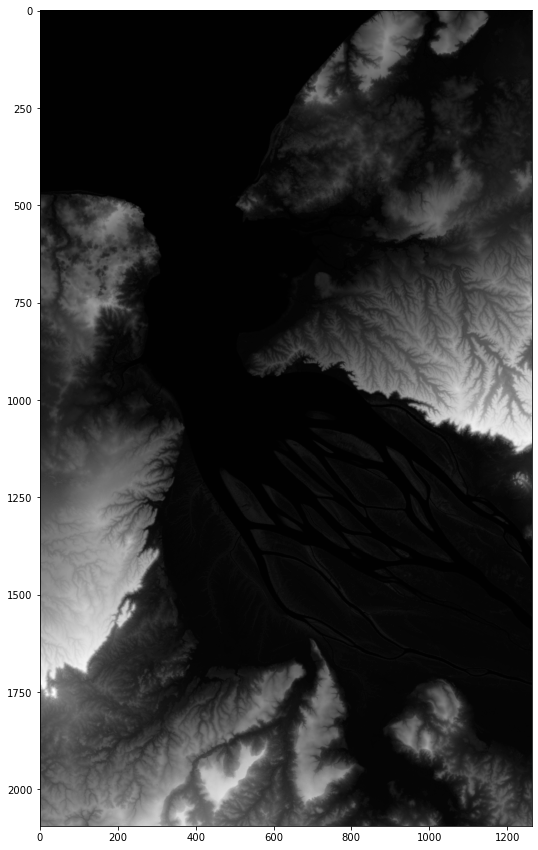

In [10]:
## plot the dem
plt.figure(figsize=(12,15))
plt.imshow(copernicus_dem, cmap = 'Greys_r')


### 2. Mapzen DEM 
To access Mapzen DEM, specify `data_collection=DataCollection.DEM_MAPZEN`

In [11]:
evalscript_orthometric_heights = """
//VERSION=3

function setup() {
  return {
    input: ["DEM"],
    output:{ 
      id: "default",
      bands: 1, 
      sampleType: SampleType.FLOAT32
    }
  }
}

function evaluatePixel(sample) {
  return [sample.DEM]
}
"""
request_orthometric_height = SentinelHubRequest(
    evalscript=evalscript_orthometric_heights,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.DEM_MAPZEN,
            time_interval=time_interval # DEM is static data, does not depend on date
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
)
## get dem data
mapzen_dem = request_orthometric_height.get_data()[0]


### Plot Copernicus and Mapzen DEM

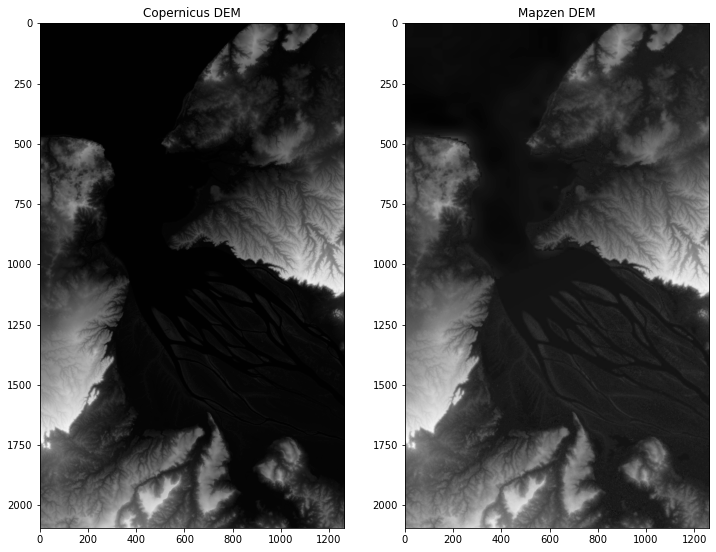

In [12]:
fig, (ax, ax1) = plt.subplots(1,2, figsize=(12, 15))
ax.imshow(copernicus_dem, cmap="Greys_r")
ax1.imshow(mapzen_dem, cmap="Greys_r")
ax.set_title("Copernicus DEM")
ax1.set_title("Mapzen DEM")
plt.show()

## Color Visualisation
In the next example, we define an evalscript that returns color visualisation of `DEM` band in the default UINT8 format.  

### 3. Copernicus 90m  DEM  
 The same color visualisation can be requested for `DEM_COPERNICUS_30`  and  `DEM_MAPZEN ` by adjusting the `data_collection` accordingly
 

In [13]:
evalscript_colour_visualisation = """
  //VERSION=3

function setup() {
  return {
    input: ["DEM"],
    output:{ 
      id: "default",
      bands:3
    }
  }
}

function evaluatePixel(sample) {
return colorBlend(sample.DEM, [-12000,-9000,-6000,-1000,-500,-200,-50,-20,-10,0,10,30,50,200,300,400,500,1000,3000,5000,7000,9000],
[[0.000, 0.000, 0.157],
[0.118, 0.000, 0.353],
[0.118, 0.118, 0.471],
[0.157, 0.196, 0.706],
[0.235, 0.235, 0.902],
[0.235, 0.314, 0.961],
[0.353, 0.333, 0.980],
[0.471, 0.471, 0.922],
[0.627, 0.627, 1.000],
[0.784, 0.784, 0.784],
[0.392, 0.220, 0.235],
[0.471, 0.180, 0.157],
[0.549, 0.298, 0.157],
[0.667, 0.376, 0.000],
[0.471, 0.220, 0.353],
[0.824, 0.573, 0.706],
[0.549, 0.431, 0.000],
[0.471, 0.549, 0.706],
[0.627, 0.667, 0.941],
[0.745, 0.784, 0.980],
[0.863, 0.941, 1.000],
[1.000, 1.000, 1.000]])
}
"""

request_colour_visualisation = SentinelHubRequest(
    evalscript=evalscript_colour_visualisation,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.DEM_COPERNICUS_90,
            time_interval=time_interval # DEM is static data, does not depend on date
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
)

In [14]:
# get the dem
vis_dem = request_colour_visualisation.get_data()[0]

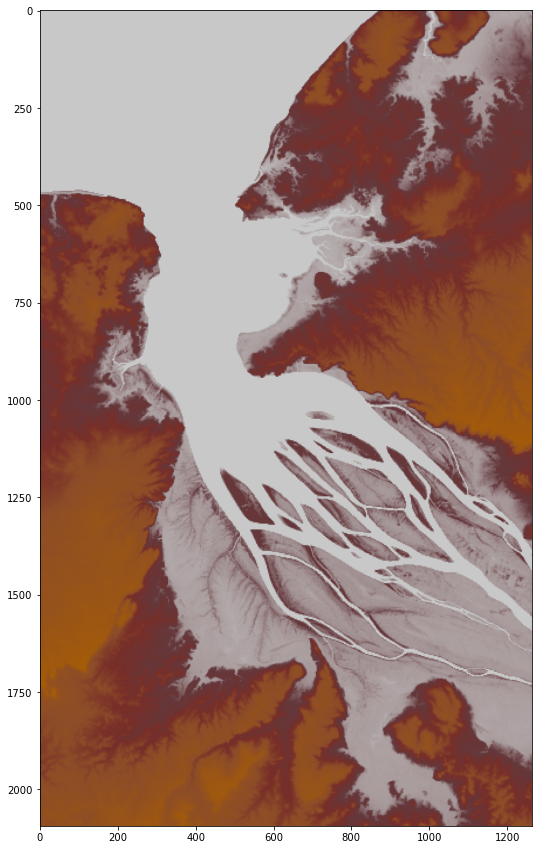

In [15]:
## plot the dem
plt.figure(figsize=(10,15))
plt.imshow(vis_dem)
